In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras import layers, Model
from tensorflow.keras.datasets import mnist
from tensorflow.keras.utils import to_categorical

In [ ]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [ ]:
import os # Import the os module
import cv2
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
# Define the path to your dataset and the categories
data_dir = '/content/drive/MyDrive/OS Collected Data/sample/Training'
categories = ['Normal', 'Osteopenia', 'Osteoporosis']
img_size = 100  # Resize images to 100x100 pixels

# Initialize lists to hold image data and labels
X = []
y = []

# Loop through each category and load images
for label in categories:
    path = os.path.join(data_dir, label)
    for img_name in os.listdir(path):
        img_path = os.path.join(path, img_name)
        img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)  # Load image in grayscale
        if img is not None:
            img = cv2.resize(img, (img_size, img_size))  # Resize image
            X.append(img)
            y.append(label)

# Convert lists to NumPy arrays
X = np.array(X)
y = np.array(y)

# Normalize pixel values to the range [0, 1]
X = X / 255.0

# Reshape X to add channel dimension
X = X.reshape(-1, img_size, img_size, 1)

# Encode labels to integers
le = LabelEncoder()
y_encoded = le.fit_transform(y)

# One-hot encode the labels
y_encoded = to_categorical(y_encoded, num_classes=3)

# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(
    X, y_encoded, test_size=0.2, random_state=42
)


In [ ]:
import tensorflow as tf
from tensorflow.keras import layers

class SelfAttention(layers.Layer):
    def __init__(self, units):
        super(SelfAttention, self).__init__()
        self.W_q = layers.Dense(units)
        self.W_k = layers.Dense(units)
        self.W_v = layers.Dense(units)
        self.scale = tf.math.sqrt(tf.cast(units, tf.float32))

    def call(self, inputs):
        q = self.W_q(inputs)
        k = self.W_k(inputs)
        v = self.W_v(inputs)

        score = tf.matmul(q, k, transpose_b=True)
        score = score / self.scale
        attention_weights = tf.nn.softmax(score, axis=-1)

        output = tf.matmul(attention_weights, v)
        return output


In [ ]:
from tensorflow.keras import layers, models

def build_baseline_model(input_shape, num_classes=3):
    inputs = layers.Input(shape=input_shape)
    x = layers.Flatten()(inputs)
    x = layers.Dense(128, activation='relu')(x)
    x = layers.Dropout(0.2)(x)
    x = layers.Dense(64, activation='relu')(x)
    x = layers.Dropout(0.2)(x)
    outputs = layers.Dense(num_classes, activation='softmax')(x)

    model = models.Model(inputs, outputs)
    return model


In [ ]:
def build_attention_model(input_shape, units=64, num_classes=3):
    inputs = layers.Input(shape=input_shape)
    x = layers.Reshape((input_shape[0], input_shape[1]))(inputs)  # Remove channel dimension
    x = SelfAttention(units)(x)
    x = layers.Flatten()(x)
    x = layers.Dense(128, activation='relu')(x)
    x = layers.Dropout(0.2)(x)
    x = layers.Dense(64, activation='relu')(x)
    x = layers.Dropout(0.2)(x)
    outputs = layers.Dense(num_classes, activation='softmax')(x)

    model = models.Model(inputs, outputs)
    return model


In [ ]:
# Build and compile the baseline model
baseline_model = build_baseline_model(input_shape=(img_size, img_size, 1))
baseline_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Train the baseline model
print("Training Baseline Model...")
baseline_model.fit(X_train, y_train, epochs=5, batch_size=32, validation_data=(X_test, y_test))

# Build and compile the attention model
attention_model = build_attention_model(input_shape=(img_size, img_size, 1))
attention_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Train the attention model
print("Training Attention Model...")
attention_model.fit(X_train, y_train, epochs=5, batch_size=32, validation_data=(X_test, y_test))


Training Baseline Model...
Epoch 1/5
39/39 ━━━━━━━━━━━━━━━━━━━━ 3s 26ms/step - accuracy: 0.4655 - loss: 1.3740 - val_accuracy: 0.6859 - val_loss: 0.7623
Epoch 2/5
39/39 ━━━━━━━━━━━━━━━━━━━━ 2s 38ms/step - accuracy: 0.6471 - loss: 0.8212 - val_accuracy: 0.6731 - val_loss: 0.7477
Epoch 3/5
39/39 ━━━━━━━━━━━━━━━━━━━━ 3s 38ms/step - accuracy: 0.6073 - loss: 0.7970 - val_accuracy: 0.6955 - val_loss: 0.7384
Epoch 4/5
39/39 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step - accuracy: 0.6744 - loss: 0.7499 - val_accuracy: 0.6955 - val_loss: 0.7260
Epoch 5/5
39/39 ━━━━━━━━━━━━━━━━━━━━ 2s 18ms/step - accuracy: 0.6957 - loss: 0.7279 - val_accuracy: 0.6955 - val_loss: 0.6774
Training Attention Model...
Epoch 1/5
39/39 ━━━━━━━━━━━━━━━━━━━━ 5s 45ms/step - accuracy: 0.4826 - loss: 1.0980 - val_accuracy: 0.6667 - val_loss: 0.7951
Epoch 2/5
39/39 ━━━━━━━━━━━━━━━━━━━━ 2s 34ms/step - accuracy: 0.5976 - loss: 0.8483 - val_accuracy: 0.6731 - val_loss: 0.7831
Epoch 3/5
39/39 ━━━━━━━━━━━━━━━━━━━━ 3s 34ms/step - accuracy: 0

In [ ]:
# Evaluate the baseline model
print("Evaluating Baseline Model...")
baseline_loss, baseline_accuracy = baseline_model.evaluate(X_test, y_test)
print(f"Baseline Model Accuracy: {baseline_accuracy:.4f}")

# Evaluate the attention model
print("Evaluating Attention Model...")
attention_loss, attention_accuracy = attention_model.evaluate(X_test, y_test)
print(f"Attention Model Accuracy: {attention_accuracy:.4f}")


Evaluating Baseline Model...
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.6666 - loss: 0.6755 
Baseline Model Accuracy: 0.6955
Evaluating Attention Model...
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.6952 - loss: 0.7465
Attention Model Accuracy: 0.7019


10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 34ms/step


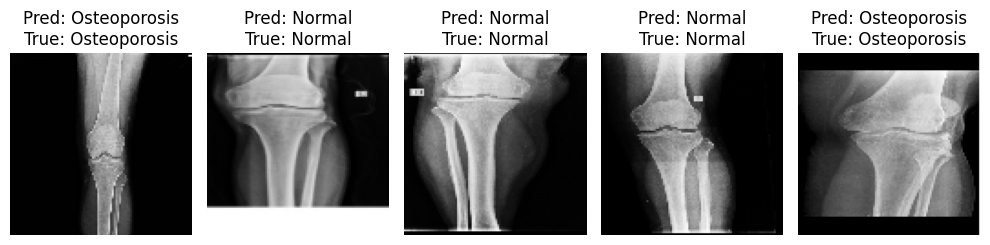

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Predict on the test set
predictions = attention_model.predict(X_test)
predicted_labels = np.argmax(predictions, axis=1)
true_labels = np.argmax(y_test, axis=1)

# Plot the first 5 test images with their predicted and true labels
plt.figure(figsize=(10, 5))
for i in range(5):
    plt.subplot(1, 5, i+1)
    plt.imshow(X_test[i].reshape(img_size, img_size), cmap='gray')
    plt.title(f"Pred: {le.classes_[predicted_labels[i]]}\nTrue: {le.classes_[true_labels[i]]}")
    plt.axis('off')
plt.tight_layout()
plt.show()


In [ ]:
# Assign the result of model.fit to the history variable
history = attention_model.fit(X_train, y_train, epochs=5, batch_size=32, validation_data=(X_test, y_test)) #This line is added



Epoch 1/5
39/39 ━━━━━━━━━━━━━━━━━━━━ 1s 35ms/step - accuracy: 0.7490 - loss: 0.5857 - val_accuracy: 0.7179 - val_loss: 0.6959
Epoch 2/5
39/39 ━━━━━━━━━━━━━━━━━━━━ 4s 63ms/step - accuracy: 0.7599 - loss: 0.5709 - val_accuracy: 0.7147 - val_loss: 0.6975
Epoch 3/5
39/39 ━━━━━━━━━━━━━━━━━━━━ 3s 79ms/step - accuracy: 0.7519 - loss: 0.5519 - val_accuracy: 0.7083 - val_loss: 0.6498
Epoch 4/5
39/39 ━━━━━━━━━━━━━━━━━━━━ 3s 34ms/step - accuracy: 0.7661 - loss: 0.5446 - val_accuracy: 0.7340 - val_loss: 0.6828
Epoch 5/5
39/39 ━━━━━━━━━━━━━━━━━━━━ 3s 34ms/step - accuracy: 0.7954 - loss: 0.4944 - val_accuracy: 0.7083 - val_loss: 0.6693


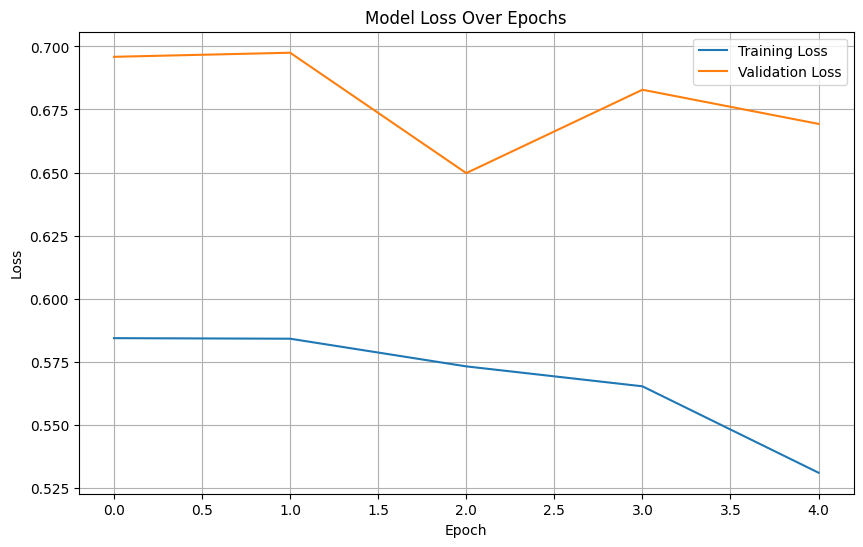

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()

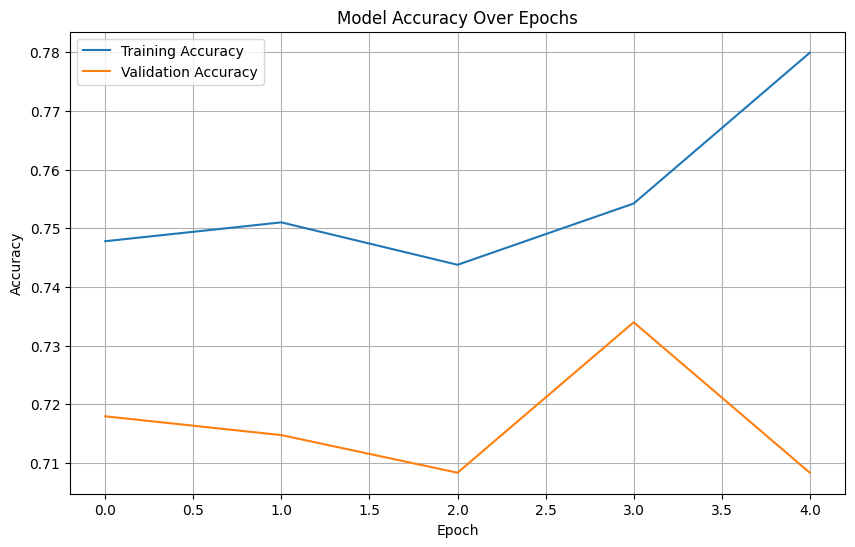

In [ ]:
plt.figure(figsize=(10, 6))
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.show()


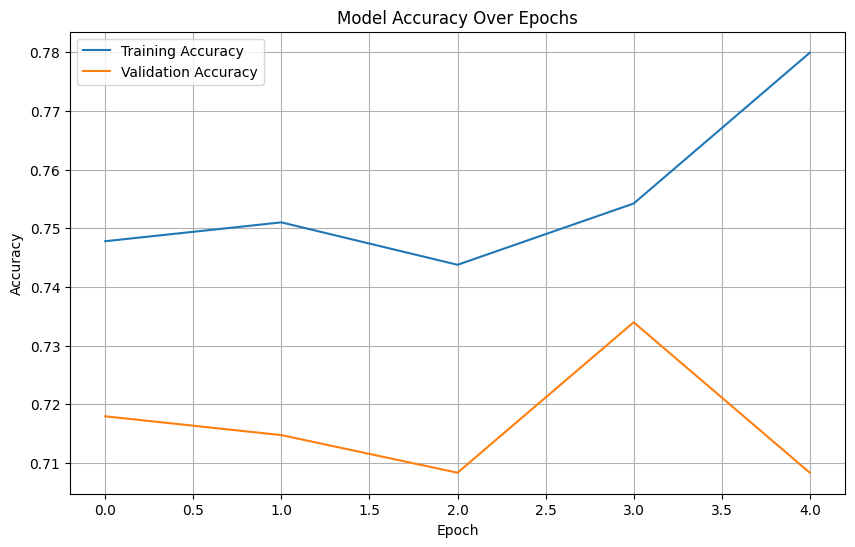

In [ ]:
plt.figure(figsize=(10, 6))
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.show()
